### Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn.base as skb
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
import sklearn.linear_model as sklm
import sklearn.neighbors as skn
import sklearn.ensemble as ske
import catboost as cb
import scipy.stats as sstats
import random

seed = 24
np.random.seed(seed)

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)

from datetime import date

import time

### IMPORT DATA

In [2]:
data_dir = './data/'
train_file = data_dir + "train.csv"
test_file = data_dir + "test.csv"

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [3]:
# SET TARGET FEATURES
target_disorder = 'Genetic Disorder'
target_subclass = 'Disorder Subclass'

# REMOVE PatientID and duplicates from train data
train_df.drop(['Patient Id'], inplace=True, axis=1)
train_df.drop_duplicates(inplace=True)

# REMOVE INRELEVANT ATTRIBUTES
irrelevant_cols = [
    'Patient First Name',
    'Family Name',
    "Father's name",
    "Father's age",
    "Mother's age",
    'Institute Name',
    'Location of Institute',
    'Status',
    'Parental consent',
    'Autopsy shows birth defect (if applicable)',
    'Place of birth',
    'No. of previous abortion',
    "Test 1","Test 2","Test 3","Test 4","Test 5",
]


train_df.drop(irrelevant_cols, inplace=True, axis=1)
test_df.drop(irrelevant_cols, inplace=True, axis=1)

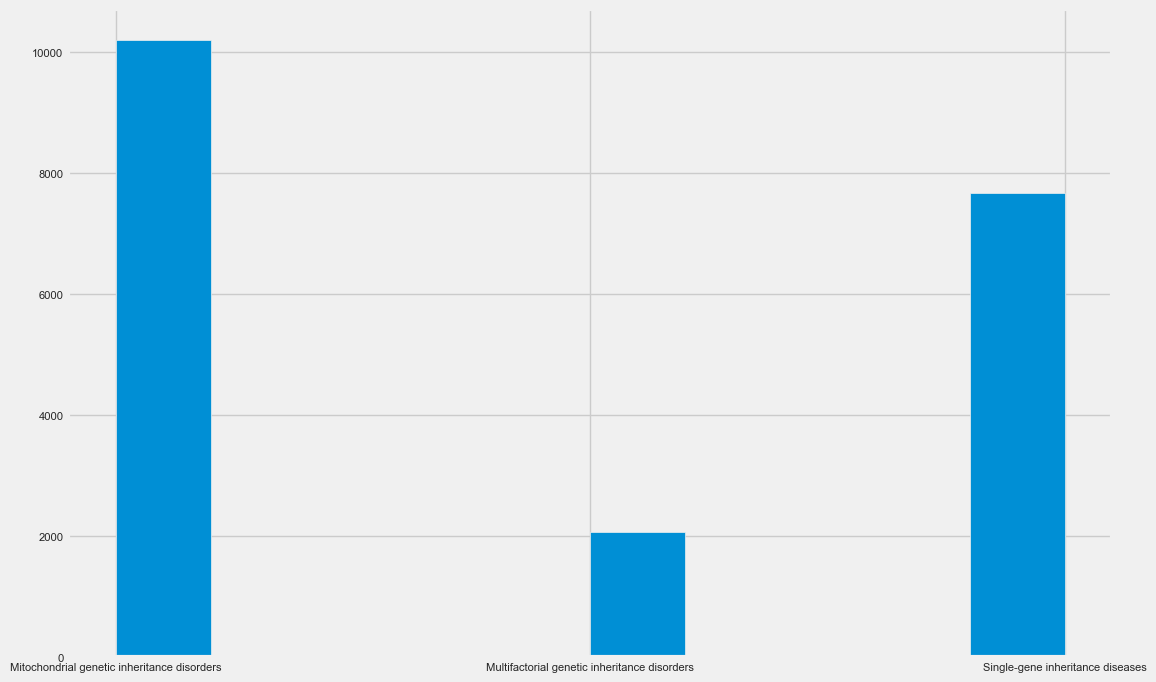

In [4]:
train_df[target_disorder].hist()
plt.show()

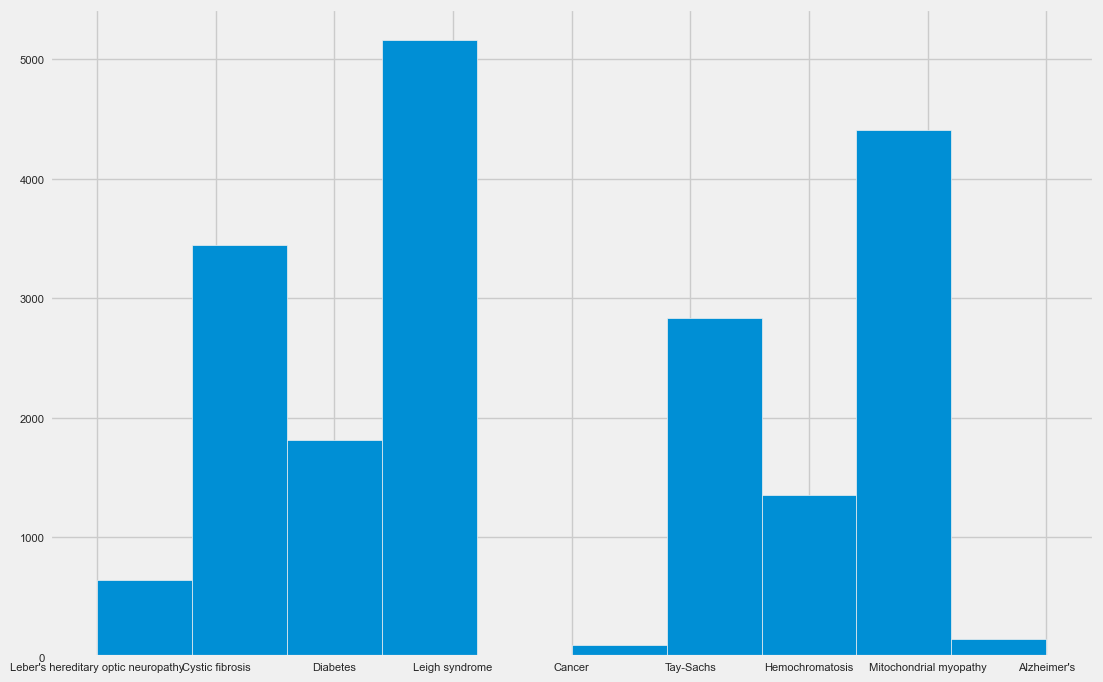

In [5]:
train_df[target_subclass].hist()
plt.show()

In [6]:
train_df.dropna(axis=1, how="all", inplace=True)
train_df.dropna(axis=0, how="all", inplace=True)
train_df.dropna(subset=[target_disorder, target_subclass], how='any', inplace=True)

test_df.dropna(axis=1, how="all", inplace=True)

In [7]:
fill_nan_dict = {
    'Assisted conception IVF/ART': 'Yes',
    'H/O radiation exposure (x-ray)': '-',
    'Respiratory Rate (breaths/min)': 'Normal (30-60)',
    'Folic acid details (peri-conceptional)': 'Yes',
    'H/O serious maternal illness': 'No',
    'Birth asphyxia': 'Not available',
    'Birth defects': 'Singular',
    'Blood test result': 'inconclusive',
    'H/O substance abuse': '-',
    'White Blood cell count (thousand per microliter)': train_df['White Blood cell count (thousand per microliter)'].mean(),
    'History of anomalies in previous pregnancies': 'No',
    'Inherited from father': 'No',
    'Gender': 'Ambiguous',
    'Follow-up': 'Low',
    'Maternal gene': 'No',
    'Patient Age': train_df['Patient Age'].mean(),
    'Symptom 1': train_df['Symptom 1'].mode()[0],
    'Symptom 2': train_df['Symptom 2'].mode()[0],
    'Symptom 3': train_df['Symptom 3'].mode()[0],
    'Symptom 4': train_df['Symptom 4'].mode()[0],
    'Symptom 5': train_df['Symptom 5'].mode()[0],
    'Heart Rate (rates/min': train_df['Heart Rate (rates/min'].mode()[0]
}

for i in fill_nan_dict:
    train_df[i].fillna(fill_nan_dict[i], inplace=True)
    test_df[i].fillna(fill_nan_dict[i], inplace=True)

In [8]:
train_df.dropna(axis=1, how="all", inplace=True)
train_df.dropna(axis=0, how="all", inplace=True)
train_df.dropna(subset=[target_disorder, target_subclass], how='any', inplace=True)

test_df.dropna(axis=1, how="all", inplace=True)

In [9]:

#ONE HOT ENCODING
one_hot = [
    "Genes in mother's side",
    'Inherited from father',
    'Maternal gene',
    'Paternal gene',
    'Respiratory Rate (breaths/min)',
    'Heart Rate (rates/min',
    'Follow-up',
    'Gender',
    'Birth asphyxia',
    'Folic acid details (peri-conceptional)',
    'H/O serious maternal illness',
    'H/O radiation exposure (x-ray)',
    'H/O substance abuse',
    'Assisted conception IVF/ART',
    'History of anomalies in previous pregnancies',
    'Birth defects',
    'Blood test result'
]

for feat in one_hot:
    train_dummies = pd.get_dummies(train_df[feat], drop_first=True, prefix=feat+"_", dtype=float)
    train_df = pd.concat([train_df, train_dummies], axis=1)
    train_df.drop(feat, axis=1, inplace=True)

    test_dummies = pd.get_dummies(test_df[feat], drop_first=True, prefix=feat+"_", dtype=float)
    test_df = pd.concat([test_df, test_dummies], axis=1)
    test_df.drop(feat, axis=1, inplace=True)

In [10]:
train_df_disorder = train_df.sample(frac=1, random_state=seed).reset_index(drop=True)
train_df_subclass = train_df.sample(frac=1, random_state=seed).reset_index(drop=True)

train_df_disorder.drop(target_subclass, inplace=True, axis=1)

le = skp.LabelEncoder()
train_df_subclass[target_disorder] = le.fit_transform(train_df_subclass[target_disorder])

In [11]:
train_df_disorder_shuffle = train_df_disorder.sample(frac=1, random_state=seed).reset_index(drop=True)

train_df_disorder_y = train_df_disorder_shuffle.pop(target_disorder)
train_df_disorder_X = train_df_disorder_shuffle

disorder_label = skp.LabelEncoder()
train_df_disorder_y = disorder_label.fit_transform(train_df_disorder_y)

X_disorder_train, X_disorder_test, y_disorder_train, y_disorder_test = skms.train_test_split(train_df_disorder_X, train_df_disorder_y, train_size=0.7, random_state=seed)

In [12]:
train_df_subclass_shuffle = train_df_subclass.sample(frac=1, random_state=seed).reset_index(drop=True)

train_df_subclass_y = train_df_subclass_shuffle.pop(target_subclass)
train_df_subclass_X = train_df_subclass_shuffle

subclass_label = skp.LabelEncoder()
train_df_subclass_y = subclass_label.fit_transform(train_df_subclass_y)

X_subclass_train, X_subclass_test, y_subclass_train, y_subclass_test = skms.train_test_split(train_df_subclass_X, train_df_subclass_y, train_size=0.7, random_state=seed)

In [13]:
# FEATURE SCALING
numerical_features = train_df.select_dtypes(include=[np.number])
X_disorder_train.reset_index(drop=True, inplace=True)
X_disorder_test.reset_index(drop=True, inplace=True)
X_disorder_train.index[:5]

scaler = skp.StandardScaler()

X_disorder_train[numerical_features.columns] = pd.DataFrame(scaler.fit_transform(X_disorder_train[numerical_features.columns]), columns=numerical_features.columns)

X_disorder_test[numerical_features.columns] = pd.DataFrame(scaler.transform(X_disorder_test[numerical_features.columns]), columns=numerical_features.columns)

# view sample data
X_disorder_train.describe()

,Patient Age,Blood cell count (mcL),White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genes in mother's side__Yes,Inherited from father__Yes,Maternal gene__Yes,Paternal gene__Yes,Respiratory Rate (breaths/min)__Tachypnea,Heart Rate (rates/min__Tachycardia,Follow-up__Low,Gender__Female,Gender__Male,Birth asphyxia__No record,Birth asphyxia__Not available,Birth asphyxia__Yes,Folic acid details (peri-conceptional)__Yes,H/O serious maternal illness__Yes,H/O radiation exposure (x-ray)__No,H/O radiation exposure (x-ray)__Not applicable,H/O radiation exposure (x-ray)__Yes,H/O substance abuse__No,H/O substance abuse__Not applicable,H/O substance abuse__Yes,Assisted conception IVF/ART__Yes,History of anomalies in previous pregnancies__Yes,Birth defects__Singular,Blood test result__inconclusive,Blood test result__normal,Blood test result__slightly abnormal
count,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00
mean,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.66,-3.57,-1.77,-1.31,-1.21,-1.16,-0.92,-0.85,-1.21,-0.80,-0.98,-0.88,-0.92,-0.91,-1.11,-0.66,-0.66,-0.54,-0.68,-0.55,-1.10,-0.91,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,-1.10,-0.92,-1.10,-0.68,-0.54,-0.56
25%,-0.94,-0.68,-0.73,-1.31,-1.21,-1.16,-0.92,-0.85,-1.21,-0.80,-0.98,-0.88,-0.92,-0.91,-1.11,-0.66,-0.66,-0.54,-0.68,-0.55,-1.10,-0.91,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,-1.10,-0.92,-1.10,-0.68,-0.54,-0.56
50%,0.00,0.00,0.00,0.76,0.82,0.86,-0.92,-0.85,0.83,-0.80,-0.98,-0.88,-0.92,-0.91,0.90,-0.66,-0.66,-0.54,-0.68,-0.55,0.91,-0.91,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,0.91,-0.92,0.91,-0.68,-0.54,-0.56
75%,0.73,0.68,0.72,0.76,0.82,0.86,1.09,1.18,0.83,1.25,1.02,1.14,1.09,1.10,0.90,1.53,1.50,-0.54,1.47,-0.55,0.91,1.10,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,0.91,1.09,0.91,1.47,-0.54,-0.56
max,1.69,3.56,1.79,0.76,0.82,0.86,1.09,1.18,0.83,1.25,1.02,1.14,1.09,1.10,0.90,1.53,1.50,1.85,1.47,1.81,0.91,1.10,1.84,1.83,1.81,1.82,1.87,1.84,0.91,1.09,0.91,1.47,1.86,1.78


In [14]:
numerical_features = train_df.select_dtypes(include=[np.number])

X_subclass_train.reset_index(drop=True, inplace=True)
X_subclass_test.reset_index(drop=True, inplace=True)
X_subclass_train.index[:5]

scaler = skp.StandardScaler()

X_subclass_train[numerical_features.columns] = pd.DataFrame(scaler.fit_transform(X_subclass_train[numerical_features.columns]), columns=numerical_features.columns)

X_subclass_test[numerical_features.columns] = pd.DataFrame(scaler.transform(X_subclass_test[numerical_features.columns]), columns=numerical_features.columns)

X_subclass_train.describe()

,Patient Age,Blood cell count (mcL),White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Genes in mother's side__Yes,Inherited from father__Yes,Maternal gene__Yes,Paternal gene__Yes,Respiratory Rate (breaths/min)__Tachypnea,Heart Rate (rates/min__Tachycardia,Follow-up__Low,Gender__Female,Gender__Male,Birth asphyxia__No record,Birth asphyxia__Not available,Birth asphyxia__Yes,Folic acid details (peri-conceptional)__Yes,H/O serious maternal illness__Yes,H/O radiation exposure (x-ray)__No,H/O radiation exposure (x-ray)__Not applicable,H/O radiation exposure (x-ray)__Yes,H/O substance abuse__No,H/O substance abuse__Not applicable,H/O substance abuse__Yes,Assisted conception IVF/ART__Yes,History of anomalies in previous pregnancies__Yes,Birth defects__Singular,Blood test result__inconclusive,Blood test result__normal,Blood test result__slightly abnormal
count,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00,12632.00
mean,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.87,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.94,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.66,-3.57,-1.77,-1.31,-1.21,-1.16,-0.92,-0.85,0.00,-1.21,-0.80,-0.98,-0.88,-0.92,-0.91,-1.11,-0.66,-0.66,-0.54,-0.68,-0.55,-1.10,-0.91,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,-1.10,-0.92,-1.10,-0.68,-0.54,-0.56
25%,-0.94,-0.68,-0.73,-1.31,-1.21,-1.16,-0.92,-0.85,0.00,-1.21,-0.80,-0.98,-0.88,-0.92,-0.91,-1.11,-0.66,-0.66,-0.54,-0.68,-0.55,-1.10,-0.91,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,-1.10,-0.92,-1.10,-0.68,-0.54,-0.56
50%,0.00,0.00,0.00,0.76,0.82,0.86,-0.92,-0.85,0.00,0.83,-0.80,-0.98,-0.88,-0.92,-0.91,0.90,-0.66,-0.66,-0.54,-0.68,-0.55,0.91,-0.91,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,0.91,-0.92,0.91,-0.68,-0.54,-0.56
75%,0.73,0.68,0.72,0.76,0.82,0.86,1.09,1.18,2.00,0.83,1.25,1.02,1.14,1.09,1.10,0.90,1.53,1.50,-0.54,1.47,-0.55,0.91,1.10,-0.54,-0.55,-0.55,-0.55,-0.54,-0.54,0.91,1.09,0.91,1.47,-0.54,-0.56
max,1.69,3.56,1.79,0.76,0.82,0.86,1.09,1.18,2.00,0.83,1.25,1.02,1.14,1.09,1.10,0.90,1.53,1.50,1.85,1.47,1.81,0.91,1.10,1.84,1.83,1.81,1.82,1.87,1.84,0.91,1.09,0.91,1.47,1.86,1.78


In [15]:
class_weights_disorder = sku.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_disorder_train), y=y_disorder_train)
class_weights_disorder = dict(enumerate(class_weights_disorder))
sample_weights_disorder = sku.class_weight.compute_sample_weight('balanced', y_disorder_train)
sample_weights_disorder

array([0.65301902, 0.65301902, 0.65301902, ..., 0.65301902, 0.65301902,
       0.86603592])

In [16]:
class_weights_subclass = sku.class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_subclass_train), y=y_subclass_train)
class_weights_subclass = dict(enumerate(class_weights_subclass))
sample_weights_subclass = sku.class_weight.compute_sample_weight('balanced', y_subclass_train)
sample_weights_subclass

array([0.50615058, 0.42948456, 0.50615058, ..., 3.44853945, 0.42948456,
       1.58953064])

### BUILDING MODEL

In [17]:
disorder_params = {
    "objective" :'multi:softprob', 
    "random_state":seed,
    "scoring":'f1', 
    "learning_rate":0.03,
    "subsample":0.5,
    "n_jobs":-1,
    "sample_weight":sample_weights_disorder,
    "n_estimators":100,
    "max_depth" : 8
}

subclass_params = {
    "objective" :'multi:softprob',
    "random_state":seed,
    "scoring":'f1', 
    "learning_rate":0.03,
    "subsample":1,
    "n_jobs":-1,
    "sample_weight":sample_weights_subclass,
    "n_estimators":100,
    "max_depth" : 5
}

# concrete_disorder_params = {
#     'n_bits': 4,
#     **disorder_params,
# }

# concrete_subclass_params = {
#     'n_bits': 4,
#     **subclass_params,
# }


### BASE MODEL

In [18]:
from xgboost import XGBClassifier

In [19]:

xgb_disorder_model = XGBClassifier(**disorder_params)
xgb_disorder_model.fit(X_disorder_train, y_disorder_train)

y_disorder_train_pred = xgb_disorder_model.predict(X_disorder_train)
y_disorder_test_pred = xgb_disorder_model.predict(X_disorder_test)

print("SKLearn XGBoost Disorder Model Accuracy", skm.accuracy_score(y_disorder_train, y_disorder_train_pred))
# print(skm.accuracy_score(y_disorder_test, y_disorder_test_pred))


[22:09:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "sample_weight", "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SKLearn XGBoost Disorder Model Accuracy 0.796785940468651


In [20]:
xgb_subclass_model = XGBClassifier(**subclass_params)
xgb_subclass_model.fit(X_subclass_train, y_subclass_train)

y_subclass_train_pred = xgb_subclass_model.predict(X_subclass_train)
y_subclass_test_pred = xgb_subclass_model.predict(X_subclass_test)

print("SKLearn XGBoost Sublass Model Accuracy",skm.accuracy_score(y_subclass_train, y_subclass_train_pred))
# print(skm.accuracy_score(y_subclass_test, y_subclass_test_pred))

[22:09:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "sample_weight", "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


SKLearn XGBoost Sublass Model Accuracy 0.7408169727675744


### CONCRETE MODELS

In [21]:
from concrete.ml.sklearn.xgb import XGBClassifier as ConcreteXGBClassifier

concrete_disorder_params = {
    'n_bits': 4,
    **disorder_params,
}

concrete_subclass_params = {
    'n_bits': 4,
    **subclass_params,
}

In [22]:

concrete_disorder_model = ConcreteXGBClassifier(**concrete_disorder_params)
concrete_disorder_model.fit(X_disorder_train, y_disorder_train)

y_fhe_disorder_train_pred = concrete_disorder_model.predict(X_disorder_train)
y_fhe_disorder_test_pred = concrete_disorder_model.predict(X_disorder_test)

print("ConcreteML XGBClassifier Disorder Accuracy: ",skm.accuracy_score(y_disorder_train, y_fhe_disorder_train_pred))

# print(skm.accuracy_score(y_disorder_test, y_fhe_disorder_test_pred))

ConcreteML XGBClassifier Disorder Accuracy:  0.8023274224192527


In [23]:
concrete_subclass_model = ConcreteXGBClassifier(**concrete_subclass_params)
concrete_subclass_model.fit(X_subclass_train, y_subclass_train)

y_fhe_subclass_train_pred = concrete_subclass_model.predict(X_subclass_train)
y_fhe_subclass_test_pred = concrete_subclass_model.predict(X_subclass_test)

print("ConcreteML XGBClassifier Subclass Accuracy: ", skm.accuracy_score(y_subclass_train, y_fhe_subclass_train_pred))
# print(skm.accuracy_score(y_subclass_test, y_fhe_subclass_test_pred))

ConcreteML XGBClassifier Subclass Accuracy:  0.7312381253958201


### GENERATE KEY

In [24]:
from concrete.compiler import check_gpu_available

use_gpu_if_available = False
device = "cuda" if use_gpu_if_available and check_gpu_available() else "cpu"

circuit_disorder = concrete_disorder_model.compile(X_disorder_train, device=device)
# circuit_disorder.client.keygen(force=False)

circuit_subclass = concrete_subclass_model.compile(X_subclass_train, device=device)
# circuit_subclass.client.keygen(force=False)

In [25]:
circuit_disorder.client.keygen(force=False)
circuit_subclass.client.keygen(force=False)

### EVALUATE MODEL

In [26]:
# Compute the predictions using the Scikit-Learn model
disorder_pred_sklearn = xgb_disorder_model.predict(X_disorder_test)
disorder_pred_fhe = concrete_disorder_model.predict(X_disorder_test, fhe="simulate")

subclass_pred_sklearn = xgb_subclass_model.predict(X_subclass_test)
subclass_pred_fhe = concrete_subclass_model.predict(X_subclass_test, fhe="simulate")


print("Accuracy scores:")
print(
    f"- Scikit-Learn for disorder (clear floating points): {skm.accuracy_score(y_disorder_test, disorder_pred_sklearn)*100:.2f}%\n"
    f"- Concrete ML for disorder (clear quantized): {skm.accuracy_score(y_disorder_test, disorder_pred_fhe)*100:.2f}%\n"
    f"- Scikit-Learn for subclass (clear floating points): {skm.accuracy_score(y_subclass_test, subclass_pred_sklearn)*100:.2f}%\n"
    f"- Concrete ML for subclass (clear quantized): {skm.accuracy_score(y_subclass_test, subclass_pred_fhe)*100:.2f}%\n"
)

Accuracy scores:
- Scikit-Learn for disorder (clear floating points): 58.60%
- Concrete ML for disorder (clear quantized): 59.00%
- Scikit-Learn for subclass (clear floating points): 70.23%
- Concrete ML for subclass (clear quantized): 69.86%



In [33]:
# import time

N_SAMPLE_FHE = 5

# Pick N_SAMPLE_FHE random samples from the test set
idx_test = np.random.choice(X_disorder_test.shape[0], N_SAMPLE_FHE, replace=False)
X_disorder_test_fhe = X_disorder_test.iloc[idx_test]
y_disorder_test_fhe = y_disorder_test[idx_test]

# Compute the predictions using the Concrete ML (quantized) model in the clear
y_preds_disorder_clear = concrete_disorder_model.predict(X_disorder_test_fhe)

# Compute the predictions using the Concrete ML model in FHE
time_begin = time.time()
y_preds_disorder_fhe = concrete_disorder_model.predict(X_disorder_test_fhe, fhe="execute")
print(f"FHE execution time (Genetic Disorder): {(time.time() - time_begin) / len(X_disorder_test_fhe):.2f} seconds per sample")
# Compare the clear quantized inference vs FHE inference
print(
    f"{(y_preds_disorder_fhe == y_preds_disorder_clear).sum()}/{N_SAMPLE_FHE} "
    "Genetic Disorder: FHE predictions match the clear quantized predictions"
)

FHE execution time (Genetic Disorder): 1241.70 seconds per sample
5/5 Genetic Disorder: FHE predictions match the clear quantized predictions


In [34]:
# Pick N_SAMPLE_FHE random samples from the test set
idx_test = np.random.choice(X_subclass_test.shape[0], N_SAMPLE_FHE, replace=False)
X_subclass_test_fhe = X_subclass_test.iloc[idx_test]
y_subclass_test_fhe = y_subclass_test[idx_test]

# Compute the predictions using the Concrete ML (quantized) model in the clear
y_preds_subclass_clear = concrete_subclass_model.predict(X_subclass_test_fhe)

# Compute the predictions using the Concrete ML model in FHE
time_begin = time.time()
y_preds_subclass_fhe = concrete_subclass_model.predict(X_subclass_test_fhe, fhe="execute")
print(f"FHE execution time: {(time.time() - time_begin) / len(X_subclass_test_fhe):.2f} seconds per sample")
# Compare the clear quantized inference vs FHE inference
print(
    f"{(y_preds_subclass_fhe == y_preds_subclass_clear).sum()}/{N_SAMPLE_FHE} "
    "Disorder Subclass: FHE predictions match the clear quantized predictions"
)

FHE execution time: 344.72 seconds per sample
5/5 Disorder Subclass: FHE predictions match the clear quantized predictions


### DEPLOYMENT

In [35]:
from concrete.ml.deployment import FHEModelClient, FHEModelServer, FHEModelDev

disorder_fhe_dir = './tmp/disorder/fhe_client_server_files/'
disorder_key_dir = "./tmp/disorder/keys_client"

disorder_dev = FHEModelDev(path_dir=disorder_fhe_dir, model=concrete_disorder_model)
disorder_dev.save()

disorder_client = FHEModelClient(path_dir=disorder_fhe_dir, key_dir=disorder_key_dir)
disorder_serialized_evaluation_keys = disorder_client.get_serialized_evaluation_keys()

# Setup the server
server = FHEModelServer(path_dir=disorder_fhe_dir)
server.load()


KeySetCache: miss, regenerating ./tmp/disorder/keys_client/15751302961461149113


In [37]:
encrypted_data = disorder_client.quantize_encrypt_serialize(np.array([X_disorder_test.iloc[0].values]))

encrypted_result = server.run(encrypted_data, disorder_serialized_evaluation_keys)

# # Client decrypts the result
result = np.array(disorder_client.deserialize_decrypt_dequantize(encrypted_result)).argmax(axis=1)